In [138]:
import os
from glob import glob
import copy
from datetime import datetime
import distutils.dir_util
from shutil import copyfile
import ujson as json
import PIL


from matplotlib import pyplot as plt
%matplotlib inline
import bcolz
import numpy as np

from keras.utils.np_utils import to_categorical as one_hot

from keras.layers import Dense, Input, Lambda, BatchNormalization, Conv2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D, Activation, Flatten, Dropout
from keras.models import Model
from keras.applications.resnet50 import ResNet50, identity_block, conv_block
from keras.applications.imagenet_utils import preprocess_input
from keras.regularizers import l2

from keras.optimizers import Adam
from keras import backend as K

from keras.callbacks import CSVLogger
from keras.preprocessing.image import ImageDataGenerator

In [2]:
DATA_ROOT_DIR = "/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/"
TEST_STG1_DIR = DATA_ROOT_DIR + '/test_stg1/'
TEST_STG2_DIR = DATA_ROOT_DIR + '/test_stg2/'
RESULTS_DIR = DATA_ROOT_DIR + '/results/'

SAMPLE_ROOT_DIR = DATA_ROOT_DIR + "/sample/"
TRAIN_SAMPLE_DIR = SAMPLE_ROOT_DIR + '/train/'
VALID_SAMPLE_DIR = SAMPLE_ROOT_DIR + '/valid/'
TRAIN_DIR = DATA_ROOT_DIR + '/train/'
VALID_DIR = DATA_ROOT_DIR + '/valid/'

# 1. Prepare Data (create validation/sample sets, rearrange images by class dir)

In [4]:
%mkdir -p $VALID_DIR
%mkdir -p $RESULTS_DIR
%mkdir -p $TRAIN_SAMPLE_DIR
#%mkdir -p $VALID_SAMPLE_DIR # "OMITTED AS VALIDATION SIZE QUITE SMALL ANYWAY"
%mkdir -p $TEST_STG1_DIR/unknown
%mkdir -p $TEST_STG2_DIR/unknown

In [11]:
!unzip sample_submission_stg1.csv.zip
!unzip sample_submission_stg2.csv.zip
!unzip test_stg1.zip
!7za e test_stg2.7z
!unzip train.zip


7-Zip (A) [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,4 CPUs)

Processing archive: test_stg2.7z

Extracting  test_stg2/image_00001.jpg
Extracting  test_stg2/image_00002.jpg
Extracting  test_stg2/image_00003.jpg
Extracting  test_stg2/image_00004.jpg
Extracting  test_stg2/image_00005.jpg
Extracting  test_stg2/image_00006.jpg
Extracting  test_stg2/image_00007.jpg
Extracting  test_stg2/image_00008.jpg
Extracting  test_stg2/image_00009.jpg
Extracting  test_stg2/image_00010.jpg
Extracting  test_stg2/image_00011.jpg
Extracting  test_stg2/image_00012.jpg
Extracting  test_stg2/image_00013.jpg
Extracting  test_stg2/image_00014.jpg
Extracting  test_stg2/image_00015.jpg
Extracting  test_stg2/image_00016.jpg
Extracting  test_stg2/image_00017.jpg
Extracting  test_stg2/image_00018.jpg
Extracting  test_stg2/image_00019.jpg
Extracting  test_stg2/image_00020.jpg
Extracting  test_stg2/image_00021.jpg
Extracting  test_stg2/image_

In [14]:
!rm -rf __MACOSX/
!rm *.zip
!rm *.7z

In [26]:
# Quick Stats
%cd $train_dir
!ls | while read line; do echo "$line"=`ls "$line" | wc -l`; done

/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
ALB=1719
BET=200
DOL=117
LAG=67
NoF=465
OTHER=299
SHARK=176
YFT=734


In [27]:
# Total=
print(1719+200+117+67+465+299+176+734)

3777


In [47]:
# Create Validation
#num_valid_one_class = 60 # As unbalanced, let's take a percentage of each class (may e.g. oversample later)

def create_validation(class_name, sample_size):
    %cd $TRAIN_DIR
    %mkdir -p $VALID_DIR/$class_name
    g = glob(class_name+'/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(sample_size): os.rename(shuf[i], VALID_DIR + shuf[i])

In [48]:
# validation_percentage_size = 10%

create_validation("ALB", 172)
create_validation("BET", 20)
create_validation("DOL", 12)
create_validation("LAG", 7)
create_validation("NoF", 47)
create_validation("OTHER", 30)
create_validation("SHARK", 18)
create_validation("YFT", 74)

/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train


In [49]:
# Create Sample (only train as validation set quite small anyway)
def create_train_sample(class_name, sample_size):
    %cd $TRAIN_DIR/
    %mkdir -p $TRAIN_SAMPLE_DIR/$class_name
    g = glob(class_name+'/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(sample_size): copyfile(shuf[i], TRAIN_SAMPLE_DIR + shuf[i])

In [51]:
# Quick Stats (having removed some into validation)
%cd $train_dir
!ls | while read line; do echo "$line"=`ls "$line" | wc -l`; done

/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
ALB=1547
BET=180
DOL=105
LAG=60
NoF=418
OTHER=269
SHARK=158
YFT=660


In [54]:
# train_sample_percentage_size = 10%

create_train_sample("ALB", 155)
create_train_sample("BET", 18)
create_train_sample("DOL", 11)
create_train_sample("LAG", 6)
create_train_sample("NoF", 42)
create_train_sample("OTHER", 27)
create_train_sample("SHARK", 17)
create_train_sample("YFT", 66)

/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train
/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring/train


In [55]:
# Create single 'unknown' class for test set
%mv $TEST_STG1_DIR/*.jpg $TEST_STG1_DIR/unknown/
%mv $TEST_STG2_DIR/*.jpg $TEST_STG2_DIR/unknown/

mv: cannot stat ‘/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring//test_stg1//*.jpg’: No such file or directory
mv: cannot stat ‘/home/ubuntu/data/the-nature-conservancy-fisheries-monitoring//test_stg2//*.jpg’: No such file or directory


# 2. Finetune model on full data (not sample as small data)

In [3]:
def fit_generator_helper(model, result_dir_name, lr=0.1, nb_epoch=1):
    K.set_value(model.optimizer.lr, lr)
    
    now = datetime.now().strftime("%Y%m%d_%H%M%S.h5")
    results_dir = RESULTS_DIR + "/" + result_dir_name + "/"
    distutils.dir_util.mkpath(results_dir)
    
    model.fit_generator(trn_batches,
                        samples_per_epoch=trn_batches.nb_sample,
                        nb_epoch=nb_epoch,
                        validation_data=val_batches,
                        nb_val_samples=val_batches.nb_sample,
                        callbacks=[CSVLogger(results_dir+"epoch_results.csv", separator=',', append=True)])
    model.save_weights(results_dir + now )
    return model

def fit_precomputed_helper(model, result_dir_name, lr=0.1, nb_epoch=1):  
    K.set_value(model.optimizer.lr, lr)
    
    now = datetime.now().strftime("%Y%m%d_%H%M%S.h5")
    results_dir = RESULTS_DIR + "/" + result_dir_name + "/"
    distutils.dir_util.mkpath(results_dir)
    
    model.fit(trn_conv_features, trn_labels,
              batch_size=batch_size, 
              nb_epoch=nb_epoch,
              validation_data=(val_conv_features, val_labels),
              shuffle=True, 
              callbacks=[CSVLogger(results_dir+"epoch_results.csv", separator=',', append=True)])
    model.save_weights(results_dir + now)
    return model

def predict_generator_helper(model, batches):
    # Be sure get_batches has used shuffle=False
    return model.predict_generator(batches,
                                   batches.nb_sample)

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

In [4]:
# Create base model
resnet_base = ResNet50(include_top=False, weights='imagenet')

#classifier_input_shape = resnet_base.layers[-1].output_shape[1:] # i.e. shape of conv features (produces (None, None, None, 2048))
classifier_input_shape = (1, 1, 2048)
classifier_input = Input(shape=classifier_input_shape)

### Precompute convolutional output (to save training time)

In [5]:
def preprocess_input(x, data_format=None):
    # Based on function at https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py
    # Altered for 3D input, assumes data_format='channels_last'
    
    """Preprocesses a tensor encoding a batch of images.
    # Arguments
        x: input Numpy tensor, 3D.
        data_format: data format of the image tensor.
    # Returns
        Preprocessed tensor.
    """
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

# Create (Raw Image) Batches
def get_batches(path,
                gen=ImageDataGenerator(preprocessing_function=preprocess_input),
                shuffle=True,
                batch_size=64,
                target_size=(224,224),
                class_mode='categorical'):
    return gen.flow_from_directory(path, 
                                   target_size=target_size,
                                   class_mode=class_mode,
                                   shuffle=shuffle, 
                                   batch_size=batch_size)

def create_precomputed_data(model, batches):
    filenames = batches.filenames
    conv_features = predict_generator_helper(model, batches)
    labels = one_hot(batches.classes)
    return (filenames, conv_features, labels)

def get_batch_data(batches):
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

In [6]:
batch_size = 32 # multiple of 2 and as large as you can (encourages more stable training), but no larger than 64.
#trn_batches = get_batches(TRAIN_SAMPLE_DIR, batch_size=batch_size, shuffle=False)
trn_batches = get_batches(TRAIN_DIR, batch_size=batch_size, shuffle=False)
val_batches = get_batches(VALID_DIR, batch_size=batch_size, shuffle=False)

trn_filenames, trn_conv_features, trn_labels = create_precomputed_data(resnet_base, trn_batches)
val_filenames, val_conv_features, val_labels = create_precomputed_data(resnet_base, val_batches)

Found 3397 images belonging to 8 classes.
Found 380 images belonging to 8 classes.


In [7]:
%mkdir -p $RESULTS_DIR/ResNet50_conv_feats

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def save_precomputed_data(filenames, conv_feats, labels, features_base_name="ResNet50_conv_feats/trn_sample_"):
    save_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat', np.array(filenames))
    save_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat', conv_feats)
    save_array(RESULTS_DIR+"/"+features_base_name+'labels.dat', np.array(labels))
    
save_precomputed_data(trn_filenames, trn_conv_features, trn_labels, "ResNet50_conv_feats/trn_sample_")
save_precomputed_data(val_filenames, val_conv_features, val_labels, "ResNet50_conv_feats/val_")

### Run finetuning

In [8]:
def load_array(fname):
    return bcolz.open(fname)[:]

def load_precomputed_data(features_base_name="ResNet50_conv_feats/trn_sample_"):
    filenames = load_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat').tolist()
    conv_feats = load_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat')
    labels = load_array(RESULTS_DIR+"/"+features_base_name+'labels.dat')
    return filenames, conv_feats, labels
                          
trn_filenames, trn_conv_features, trn_labels = load_precomputed_data("ResNet50_conv_feats/trn_")
val_filenames, val_conv_features, val_labels = load_precomputed_data("ResNet50_conv_feats/val_")

In [12]:
# Create classifier model

x= Flatten()(classifier_input)
x = Dense(8, activation='softmax')(x)
                                                     
classifier_model_v1 = Model(classifier_input, x)

#from keras.optimizers import SGD
classifier_model_v1.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

>"Intially overfit befor worrying about reducing it (helping to ensure you have a model complex enough for the orignal data)."

In [14]:
fit_precomputed_helper(classifier_model_v1, "classifier_model_v1", lr=0.01, nb_epoch=10)
# Ran twice (i.e. num_epochs=20)

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 0s - loss: 1.2228 - acc: 0.8999 - val_loss: 1.5547 - val_acc: 0.8553

Starting to overfit, lets add some regularisation (add data augmentation later as using pre-computed features).

In [21]:
# Create classifier model
# (base on `In [23]` https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb)

p = 0.6

x = Flatten()(classifier_input)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = Dense(8, activation='softmax')(x)
                                                     
classifier_model_v2 = Model(classifier_input, x)

classifier_model_v2.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
fit_precomputed_helper(classifier_model_v2, "classifier_model_v2", lr=0.01, nb_epoch=10)
# Ran 5 times

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 0s - loss: 0.1825 - acc: 0.9394 - val_loss: 0.2043 - val_acc: 0.9500

Somewhat saturated - let's try other dropout probabilities:

In [33]:
# Create classifier model
# (base on `In [23]` https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb)

p = 0.4

x = Flatten()(classifier_input)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = Dense(8, activation='softmax')(x)
                                                     
classifier_model_v2_1 = Model(classifier_input, x)
classifier_model_v2_1.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
fit_precomputed_helper(classifier_model_v2_1, "classifier_model_v2_1", lr=0.01, nb_epoch=10)
# Ran 3 times

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 0s - loss: 0.1241 - acc: 0.9582 - val_loss: 0.1946 - val_acc: 0.9526

No real improvement - how about:

In [37]:
# Create classifier model
# (base on `In [23]` https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb)

p = 0.8

x = Flatten()(classifier_input)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = Dense(8, activation='softmax')(x)
                                                     
classifier_model_v2_2 = Model(classifier_input, x)
classifier_model_v2_2.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
fit_precomputed_helper(classifier_model_v2_2, "classifier_model_v2_2", lr=0.01, nb_epoch=10)
# Ran 5 times

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 0s - loss: 0.2749 - acc: 0.9064 - val_loss: 0.2446 - val_acc: 0.9237

Similar val_loss/val_acc, but now we're underfitting (indicating the model is not complex enough for this level of dropout). Let try a slightly different dropout strategy:

In [50]:
# Create classifier model
# (base on `In [23]` https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb)

p = 0.4

x = Flatten()(classifier_input)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(8, activation='softmax')(x)
                                                     
classifier_model_v2_3 = Model(classifier_input, x)
classifier_model_v2_3.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
fit_precomputed_helper(classifier_model_v2_3, "classifier_model_v2_3", lr=0.01, nb_epoch=10)
# Ran 4 times

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 0s - loss: 0.0784 - acc: 0.9764 - val_loss: 0.2018 - val_acc: 0.9447

Perhaps slight overfitting - let's try chainging the dropout probability value with this strategy.

In [56]:
# Create classifier model
# (base on `In [23]` https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb)

p = 0.8

x = Flatten()(classifier_input)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(8, activation='softmax')(x)
                                                     
classifier_model_v2_4 = Model(classifier_input, x)
classifier_model_v2_4.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
classifier_model_v2_4 = fit_precomputed_helper(classifier_model_v2_4, "classifier_model_v2_4", lr=0.01, nb_epoch=10)
# Ran  times

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 0s - loss: 0.1979 - acc: 0.9391 - val_loss: 0.2529 - val_acc: 0.9500

Somewhat saturated throughout. Let's the original with lowering the learning rate.

In [63]:
classifier_model_v2 = fit_precomputed_helper(classifier_model_v2, "classifier_model_v2", lr=0.01, nb_epoch=10)

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 1s - loss: 0.1439 - acc: 0.9553 - val_loss: 0.3061 - val_acc: 0.9184

In [65]:
classifier_model_v2 = fit_precomputed_helper(classifier_model_v2, "classifier_model_v2", lr=0.001, nb_epoch=10)
# Ran 3 times

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 0s - loss: 0.0412 - acc: 0.9862 - val_loss: 0.1572 - val_acc: 0.9684

Great we're overfitting again. Lets add more regularisation - perhaps weight regulisation this time (l2 adds the sum of the weights to the loss, encouraging small weights - see p2 of https://github.com/asmith26/MyMOOCs/blob/gh-pages/courses/Coursera/Machine_Learning/Week3/5.Regularisation.pdf):

In [68]:
p = 0.6

x = Flatten()(classifier_input)
x = Dense(512, activation='relu', W_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = Dense(512, activation='relu', W_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(8, activation='softmax')(x)
                                                     
classifier_model_v2_0_1 = Model(classifier_input, x)
classifier_model_v2_0_1.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
classifier_model_v2_0_1 = fit_precomputed_helper(classifier_model_v2_0_1, "classifier_model_v2_0_1", lr=0.01, nb_epoch=10)
# Ran 7 times

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 1s - loss: 1.0348 - acc: 0.8390 - val_loss: 0.9728 - val_acc: 0.8763

In [77]:
classifier_model_v2_0_1 = fit_precomputed_helper(classifier_model_v2_0_1, "classifier_model_v2_0_1", lr=0.001, nb_epoch=10)
# Ran 2 times

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 1s - loss: 0.3839 - acc: 0.9647 - val_loss: 0.4425 - val_acc: 0.9605

Perhaps too much weight regularisation - struggling to get close the results seen by "classifier_model_v2", let's lower the value:

In [89]:
p = 0.6

x = Flatten()(classifier_input)
x = Dense(512, activation='relu', W_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(8, activation='softmax')(x)
                                                     
classifier_model_v2_0_2 = Model(classifier_input, x)
classifier_model_v2_0_2.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [96]:
classifier_model_v2_0_2 = fit_precomputed_helper(classifier_model_v2_0_2, "classifier_model_v2_0_2", lr=0.01, nb_epoch=10)
# Ran 7 times

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 1s - loss: 0.6287 - acc: 0.9099 - val_loss: 0.6854 - val_acc: 0.9053

In [99]:
classifier_model_v2_0_2 = fit_precomputed_helper(classifier_model_v2_0_2, "classifier_model_v2_0_2", lr=0.001, nb_epoch=10)
# Ran 5 times

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 1s - loss: 0.2748 - acc: 0.9723 - val_loss: 0.3718 - val_acc: 0.9605

In [101]:
classifier_model_v2_0_2 = fit_precomputed_helper(classifier_model_v2_0_2, "classifier_model_v2_0_2", lr=0.0001, nb_epoch=10)
# Ran 2 times

Train on 3397 samples, validate on 380 samples
Epoch 1/10
3397/3397 [==============================] - 1s - loss: 0.1966 - acc: 0.9862 - val_loss: 0.3265 - val_acc: 0.9658

### Multi-Output

The images indicate that there is often a lot of noise in the images. Fortunately a kaggler has been through the training images and manually annotated the fish: https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/discussion/25902

In [104]:
%cd $TRAIN_DIR
%mkdir manual_annotations
%cd manual_annotations
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147332/5471/other_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/158691/5864/NoF_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5458/bet_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5459/shark_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5460/dol_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5461/yft_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5462/alb_labels.json
!wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5463/lag_labels.json

--2017-05-12 13:42:33--  https://kaggle2.blob.core.windows.net/forum-message-attachments/158691/5864/NoF_labels.json
Resolving kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)... 40.116.120.24
Connecting to kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)|40.116.120.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333927 (326K) [application/json]
Saving to: ‘NoF_labels.json’

100%[======================================>] 333,927      914KB/s   in 0.4s   

2017-05-12 13:42:34 (914 KB/s) - ‘NoF_labels.json’ saved [333927/333927]

--2017-05-12 13:42:35--  https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5458/bet_labels.json
Resolving kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)... 40.116.120.24
Connecting to kaggle2.blob.core.windows.net (kaggle2.blob.core.windows.net)|40.116.120.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82471 (81K) [application/json]
Saving to: 

In [131]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft', 'NoF']

LABELS_DIR = TRAIN_DIR + "/manual_annotations"

bb_json = {}
for c in anno_classes:
    j = json.load(open(LABELS_DIR+'/{}_labels.json'.format(c), 'r'))
    for one_file in j:
        if 'annotations' in one_file.keys() and len(one_file['annotations'])>0:
            bb_json[one_file['filename'].split('/')[-1]] = sorted(
                one_file['annotations'], key=lambda x: x['height']*x['width'])[-1]
            
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [132]:
# For any images that have no annotations, we'll create an empty bounding box.

empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

print(len(bb_json))

raw_trn_filenames = [f.split("/")[-1] for f in trn_filenames]
raw_val_filenames = [f.split("/")[-1] for f in val_filenames]

for f in raw_trn_filenames:
    if f not in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
        
print(len(bb_json))
bb_json

3762
3777


{'img_07307.jpg': {'class': 'rect',
  'height': 150.00000000000068,
  'width': 64.00000000000028,
  'x': 370.00000000000165,
  'y': 385.0000000000017},
 'img_02225.jpg': {'class': 'rect',
  'height': 237.0000000000008,
  'width': 246.0000000000008,
  'x': 347.00000000000114,
  'y': 379.00000000000125},
 'img_04464.jpg': {'class': 'rect',
  'height': 82.0,
  'width': 173.0,
  'x': 372.0,
  'y': 388.0},
 'img_06574.jpg': {'class': 'rect',
  'height': 136.00000000000068,
  'width': 39.00000000000023,
  'x': 583.0000000000028,
  'y': 377.0000000000018},
 'img_05865.jpg': {'class': 'rect',
  'height': 436.9876631450827,
  'width': 226.0281016267669,
  'x': 646.272942429126,
  'y': 115.52547416479197},
 'img_05512.jpg': {'class': 'rect',
  'height': 137.2707631338434,
  'width': 362.1253260586053,
  'x': 540.6615333247084,
  'y': 149.90304194984128},
 'img_01360.jpg': {'class': 'rect',
  'height': 100.11000000000024,
  'width': 221.37000000000052,
  'x': 458.25000000000097,
  'y': 437.100000

In [137]:
# Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

bb_params = ['height', 'width', 'x', 'y']

def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

trn_sizes = [PIL.Image.open(TRAIN_DIR+f).size for f in trn_filenames]
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_trn_filenames, trn_sizes)], 
                   ).astype(np.float32)

val_sizes = [PIL.Image.open(VALID_DIR+f).size for f in val_filenames]
val_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_val_filenames, val_sizes)], 
                   ).astype(np.float32)

In [150]:
def to_plot(img):
    # Assumes tensorflow backend
    return np.rollaxis(img, 0, 1).astype(np.uint8)

def plot(img):
    plt.imshow(to_plot(img))

def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i, bbox, data):
    bb = bbox[i]
    plot(data[i])
    plt.gca().add_patch(create_rect(bb))
    
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size, gen=ImageDataGenerator())
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

trn_data = get_data(TRAIN_DIR)
val_data = get_data(VALID_DIR)

Found 3397 images belonging to 9 classes.
Found 380 images belonging to 8 classes.


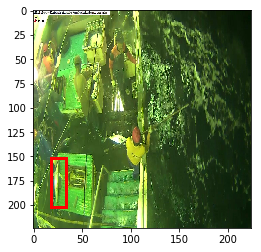

In [152]:
show_bb(0, trn_bbox, trn_data)

In [3]:
# Create classifier model
# (base on `In [23]` https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb)

p = 0.6

#x = BatchNormalization(axis=-1)(classifier_input)
#x = Flatten()(x)
x = Flatten()(classifier_input)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)
                                                     
resnet50_v1 = Model([classifier_input], [x_bb, x_class])
resnet50_v1.compile(Adam(lr=0.01), 
                    loss=['mse', 'categorical_crossentropy'],
                    metrics=['accuracy'], 
                    loss_weights=[.001, 1.])

NameError: name 'Flatten' is not defined

In [1]:
def fit_precomputed_helper_multi_output(model, result_dir_name, lr=0.1, nb_epoch=1):  
    K.set_value(model.optimizer.lr, lr)
    
    now = datetime.now().strftime("%Y%m%d_%H%M%S.h5")
    results_dir = RESULTS_DIR + "/" + result_dir_name + "/"
    distutils.dir_util.mkpath(results_dir)
    
    model.fit(trn_conv_features, [trn_bbox, trn_labels],
              batch_size=batch_size, 
              nb_epoch=nb_epoch,
              validation_data=(val_conv_features, [val_bbox, val_labels]),
              shuffle=True, 
              callbacks=[CSVLogger(results_dir+"epoch_results.csv", separator=',', append=True)])
    model.save_weights(results_dir + now)
    return model

In [2]:
resnet50_v1 = fit_precomputed_helper_multi_output(resnet50_v1, "resnet50_v1", lr=0.01, nb_epoch=5)
# Ran 5 times

NameError: name 'resnet50_v1' is not defined

### Data Augementation with classifier_model_v2

In [ ]:
We can't work from the precomputed

In [ ]:
# Create base model
resnet_base = ResNet50(include_top=False, weights='imagenet')

#classifier_input_shape = resnet_base.layers[-1].output_shape[1:] # i.e. shape of conv features (produces (None, None, None, 2048))
classifier_input_shape = (1, 1, 2048)
classifier_input = Input(shape=classifier_input_shape)

# Create classifier model
# (base on `In [23]` https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb)

p = 0.6

x = Flatten()(classifier_input)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = Dense(8, activation='softmax')(x)
                                                     
resnet50_v1 = Model(classifier_input, x)
resnet50_v1.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
classifier_model_v2_0_2 = fit_precomputed_helper(classifier_model_v2_0_2, "classifier_model_v2_0_2", lr=0.001, nb_epoch=10)
# Ran 5 times

# 3. Generate and Validate Predictions